In [231]:
from torch_geometric.datasets import QM9
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
import torch
import time

In [232]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [233]:
def plot_graph(graph_data):
    graph = to_networkx(graph_data, to_undirected=True)
    
    def visualize_graph(G):
        plt.figure(figsize=(7,7))
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True)
        plt.show()
    
    visualize_graph(graph)

In [234]:
dataset = QM9(root="./dataset/").shuffle()
dataset.y = dataset.y[:, 0]

In [235]:
data = dataset.data
print(data)
print(dataset.num_features)
print(dataset.num_classes)
print(len(dataset))

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], idx=[130831], name=[130831], z=[2359210])
11
19
130831


torch.Size([19, 11])
torch.Size([1, 19])


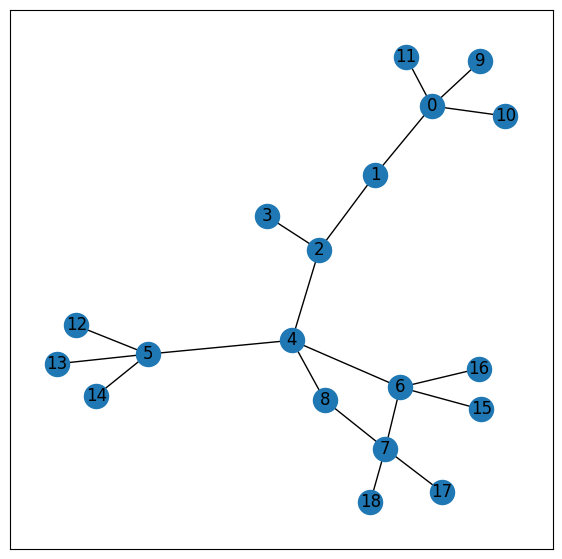

torch.Size([11, 11])
torch.Size([1, 19])


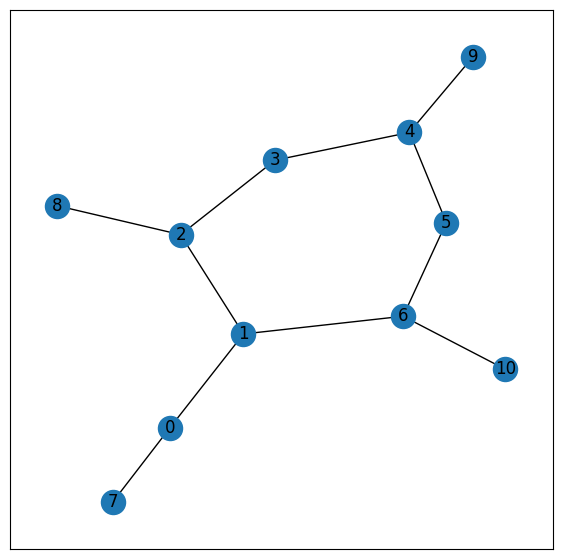

torch.Size([17, 11])
torch.Size([1, 19])


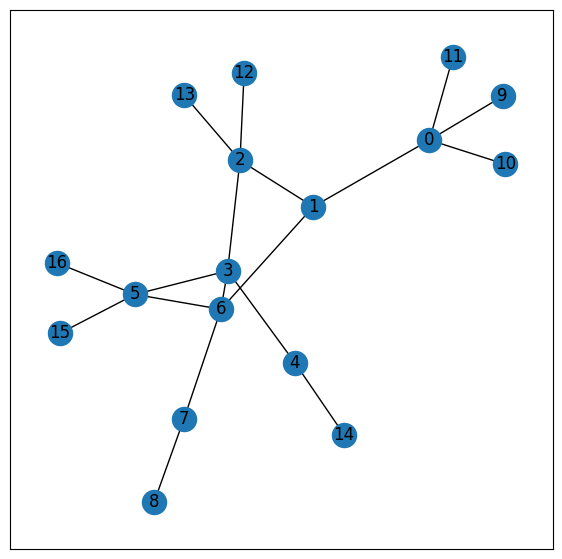

torch.Size([15, 11])
torch.Size([1, 19])


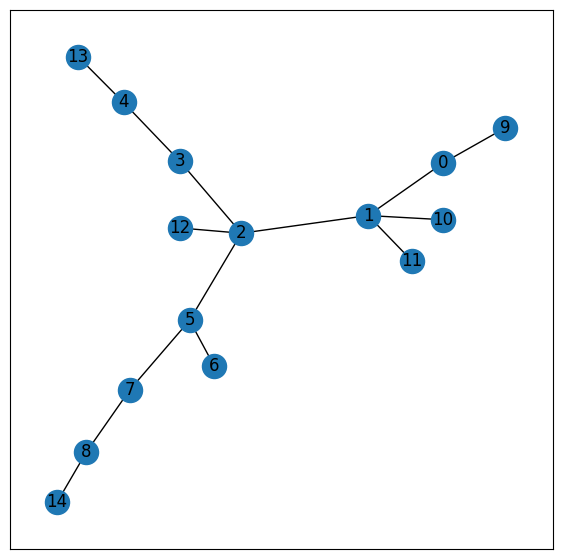

torch.Size([20, 11])
torch.Size([1, 19])


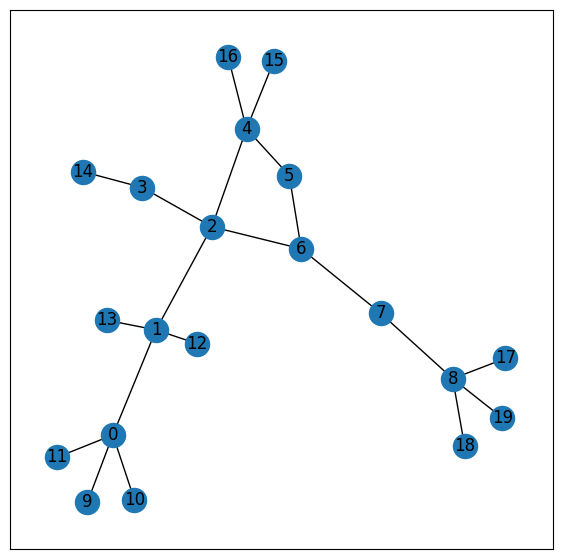

In [236]:
for idx in [0, 10, 100, 1000, 10000]:
    # idx = randint(0, len(dataset) - 1)
    data = dataset[idx]
    print(data.x.shape)
    print(data.y.shape)
    plot_graph(data)

In [237]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize=False)
        self.conv2 = GCNConv(hidden_channels, out_channels, normalize=False)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, normalize=False)
        self.conv2 = SAGEConv(hidden_channels, out_channels, normalize=False)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  


In [238]:
test_dataset = dataset[:10000]
val_dataset = dataset[10000:20000]
train_dataset = dataset[20000:]
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [249]:
# def train(model, optimizer):
#     model.train()
#     optimizer.zero_grad()
#     output = model(data)
#     loss = criterion(output, data.y)
#     loss.backward()
#     optimizer.step()
#     return float(loss)
def train(model, optimizer, criterion):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = criterion(model(data.x), data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [246]:
# @torch.no_grad()
# def test(model):
#     prediction = model(data)
#     print(prediction)
#     # accuracies = []
#     # for mask in [data.train_mask, data.val_mask, data.test_mask]:
#     # return accuracies
std = dataset.data.y.std(dim=0, keepdim=True)
def test(loader):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        error += (model(data) * std - data.y * std).abs().sum().item()  # MAE
    return error / len(loader.dataset)


In [241]:
gcn = GCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)
gat = GAT(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)
# sage = SAGEConv(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)

In [242]:
models = [gcn, gat]

In [248]:
for model in models:
    print(model)
    # compiled = model.compile()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    for epoch in range(100):
        loss = train(model, optimizer, criterion)
        print(loss)
        val_loss = test(val_loader)
        # print(f"Loss: {loss:.4f}")
        test_error = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.7f}, '
          f'Val MAE: {val_loss:.7f}, Test MAE: {test_error:.7f}')

GCN(
  (conv1): GCNConv(11, 16)
  (conv2): GCNConv(16, 19)
)


D:\GNN\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([128, 19])) that is different to the input size (torch.Size([2294, 19])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2294) must match the size of tensor b (128) at non-singleton dimension 0

In [151]:
# gcn = gcn.compile(gcn, dynamic=False)
# gat = gat.compile(gat, dynamic=False)
# sage = sage.compile(sage, dynamic=False)

In [152]:
# gcn_optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
# gat_optimizer = torch.optim.Adam(gat.parameters(), lr=0.01)
# sage_optimizer = torch.optim.Adam(sage.parameters(), lr=0.01)

In [153]:
# criterion = torch.nn.MSELoss()

In [154]:
# def train(model, optimizer):
#     model.train()
#     optimizer.zero_grad()
#     output = model(data.x, data.edge_index)
#     loss = criterion(output[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     return float(loss)
    # gcn.train()
    # gcn_optimizer.zero_grad()
    # gat.train()
    # gat_optimizer.zero_grad()
    # sage.train()
    # sage_optimizer.zero_grad()
    
    
    # gcn_output = gcn(data)
    # gat_output = gat(data)
    # sage_output = sage(data)
    # 
    # gcn_loss = criterion(
    

In [155]:
# @torch.no_grad()
# def test(model):
#     model.eval()
#     prediction = model(data.x, data.edge_index).argmax(dim=-1)
#     accuracies = []
#     for mask in [data.train_mask, data.val_mask, data.test_mask]:
#         accuracies.append(int((prediction[mask] == data.y[mask].sum()) / int(mask.sum())))
#     return accuracies